#  Plant Pathology 2020 - FGVC7
 
This is a starter kernel created for the competition ["Plant Pathology 2020 - FGVC7"](http://Plant Pathology 2020 - FGVC7).

## Problem Statement

There are many benefits in identifying diseases in agricultural crops. These benefits include reduced time, input costs and less adverse environmental impact (due to overuse of chemicals).

In this competition, we are given 1821 apple leafs to create a model which can detect diseases.
The aim is to classify the given test images into different categories like 'healthy', 'multiple_diseases','scab' and 'rust'.
Please click on the [link](http://https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview) to find the details of the problem statement.

## Data

Labels : healthy, scab, rust and multiple_diseases

1.  **train.csv** contains image_id, healthy, scab, rust and multiple_diseases
2.  **test.csv**  contains image_id

3. **images** : A folder containing the test and train images in jpg format. The name of files is in the below format


* Test files   : Test_0 to Test_1820 
* Train files  : Train_0 to Train_1820

## Note

A simple example of Transfer Learning has been shown in the kernel where we use a pretrained model of ResNet152. 

The kernel uses [fastai2](http://https://dev.fast.ai/) APIs which is a wrapper on top of PyTorch.

I'd like to thank the author of the below kernel. The kernel was very useful which creating this kernel.

[Plant Pathology 2020 - EDA + training (fastai2)](http://https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2)


### Importing the required libraries

In [1]:
# Support operations for multi-dimentional arrays and matrices
import numpy as np
# Data manipulation and analysis
import pandas as pd
# Area Under the Receiver Operating Characteristic Curve (ROC AUC)
from sklearn.metrics import roc_auc_score

###  Installing the version 2 of fastai

In [2]:
# Installing the version 2 of fastai 
!pip install -q fastai2

### Importing all the required fastaiv2 functions

In [3]:
from fastai2.vision.all import *

### Defining all the variables, hyperparameters and loading the data.

In [4]:
# Defining the Path
PATH = Path('/kaggle/input/plant-pathology-2020-fgvc7/')
IMAGE_PATH = Path('/kaggle/input/plant-pathology-2020-fgvc7/images')

LABELS = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Reading the train and test data
train_df = pd.read_csv(PATH / 'train.csv')
test_df = pd.read_csv(PATH / 'test.csv')

#Defining hyperparameters
VALIDATION_PCT = 0.2
SEED = 42
IMAGE_SIZE = 512
BATCH_SIZE = 16

### Let's have a look at the training data.

In [5]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


### Creating a function to fetch the label for a specific image.

In [6]:
def get_category(row):
    for key, value in row[LABELS].items():
        if value == 1:
            return key

A new column called 'label' is created. 
The func get_category() is used to fetch the values for this column from the training data.

In [7]:
train_df['label'] = train_df.apply(get_category, axis=1)

### Looking at the training data with the newly created column 'label'.

In [8]:
# train_df.head()
train_df.size

10926

# Data Visualization

Defining a function which can be used to load the data. It uses fastai's **datablock api** which helps in fetching the files from the given Path.

In [9]:
def load_data():
    datablock = DataBlock(blocks=(ImageBlock, CategoryBlock(vocab=LABELS)),
                          getters=[ColReader('image_id', pref=IMAGE_PATH, suff='.jpg'),
                                   ColReader('label')],
                          splitter=RandomSplitter(valid_pct = VALIDATION_PCT, seed = SEED),
                          item_tfms=Resize(IMAGE_SIZE),
                          batch_tfms=aug_transforms(size = IMAGE_SIZE, max_rotate=40., min_scale=0.80, flip_vert=True, do_flip=True)
    )
    return datablock.dataloaders(source=train_df, bs=BATCH_SIZE)

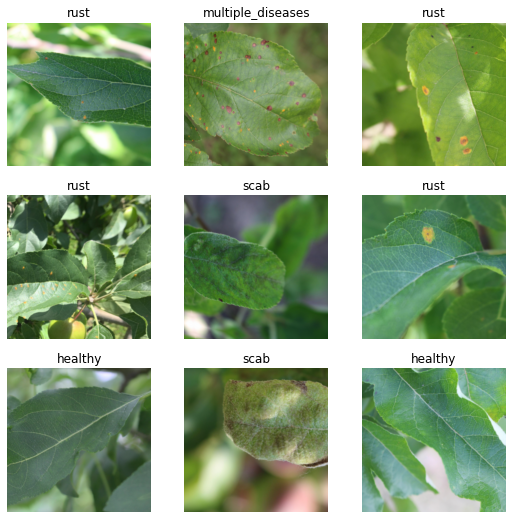

In [10]:
data = load_data()
data.show_batch()

### Defining metric functions (ROC AUC) on which the predictions are evaluated

In [11]:
def comp_metric(preds, targs, labels=range(len(LABELS))):
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

# Model

### Initializing and training our CNN model with the required parameters.

In [12]:
learn = cnn_learner(data, resnet152, metrics=[
    AccumMetric(healthy_roc_auc, flatten=False),
    AccumMetric(multiple_diseases_roc_auc, flatten=False),
    AccumMetric(rust_roc_auc, flatten=False),
    AccumMetric(scab_roc_auc, flatten=False),
    AccumMetric(comp_metric, flatten=False)]
    )
learn.fine_tune(50)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,1.103868,0.707562,0.924297,0.647965,0.973682,0.965384,0.877832,02:11


epoch,train_loss,valid_loss,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,comp_metric,time
0,0.497837,0.353484,0.982322,0.753052,0.989705,0.980761,0.926460,02:15
1,0.388768,0.287695,0.992086,0.734884,0.988579,0.985757,0.925326,02:12
2,0.271907,0.285110,0.989978,0.788517,0.990102,0.986820,0.938854,02:12
3,0.253204,0.308664,0.980067,0.760320,0.990267,0.990753,0.930352,02:13
4,0.250765,0.305764,0.987722,0.844331,0.984408,0.992063,0.952131,02:14
5,0.219576,0.387315,0.993824,0.731541,0.989539,0.990505,0.926352,02:12
6,0.272827,0.381503,0.985614,0.806831,0.989771,0.988520,0.942684,02:11
7,0.284939,0.271971,0.981213,0.852180,0.993048,0.994827,0.955317,02:12
8,0.297457,0.306295,0.944120,0.835610,0.986461,0.992666,0.939714,02:13
9,0.227125,0.279650,0.978883,0.761773,0.992386,0.995004,0.932012,02:11


### Interpretting the predictions of the model

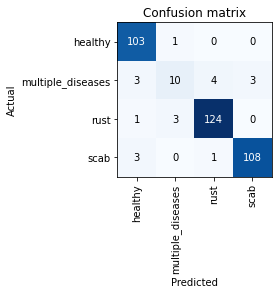

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

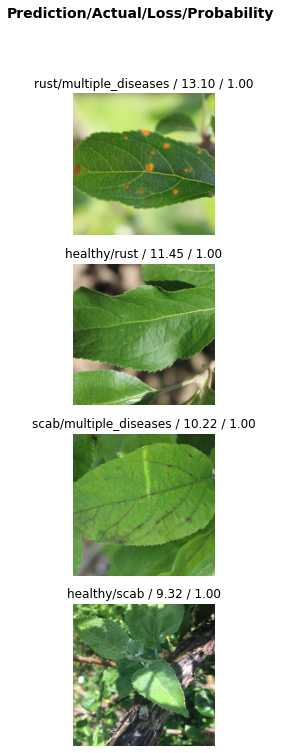

In [14]:
interp.plot_top_losses(4, nrows=4)

### Prediction of labels for the test data 

In [15]:
# Creating dataloader for the test data
test_dl = data.test_dl(test_df)
# Predicting the category of each image in test data using the trained model
test_preds, _ = learn.get_preds(dl=test_dl)

# Prediction

### Creating the test prediction dataframe and csv file

In [16]:
# Adding the column for the labels to the test data frame
test_predictions = pd.concat([test_df, pd.DataFrame(np.stack(test_preds), columns=LABELS)], axis=1)
test_predictions.to_csv('submission.csv', index=False)
test_predictions.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.001257,0.000088,9.986552e-01,5.012579e-08
1,Test_1,0.000072,0.000198,9.997291e-01,3.153711e-07
2,Test_2,0.001916,0.000151,2.544178e-08,9.979333e-01
3,Test_3,0.999997,0.000002,6.077592e-07,1.198194e-08
4,Test_4,0.000026,0.000007,9.999675e-01,4.406896e-09
